# Imports and stuff

In [ ]:
# Libraries
! python -m pip install --upgrade pip

! pip install pygame
! pip install midiutil
! pip install python-ternary
! pip install anytree
! pip install graphviz
! pip install lark-parser

In [1]:
#Imports
import numpy as np
from midiutil import MIDIFile
import matplotlib.pyplot as plt
import ternary
from ternary.helpers import simplex_iterator
# import graphviz
import anytree as at
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

# helpers
import sys
sys.path.insert(0, 'helpers/')
from tree_parser import TreeParser
# from midi import *

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [27]:
# Colormap global
from matplotlib.colors import LinearSegmentedColormap

cdict1 = {
    'red':    ((0.0,  0.0, 0.0),
               (0.01, 0.12, 0.12,),
               (0.02, 0.25, 0.25),
               (0.08, 0.38, 0.38),
               (0.16, 0.5, 0.5),
               (0.32, 0.65, 0.65),
               (0.64, 0.85, 0.85),
               (1.0,  1.0, 1.0)),

     'green': ((0.0, 0.0, 0.0),
               (1.0, 1.0, 0.0)),

     'blue':  ((0.0,  0.0, 0.0),
               (0.01, 0.12, 0.12,),
               (0.02, 0.25, 0.25),
               (0.08, 0.38, 0.38),
               (0.16, 0.5, 0.5),
               (0.32, 0.65, 0.65),
               (0.64, 0.85, 0.85),
               (1.0,  1.0, 1.0)),
    }

cmap = LinearSegmentedColormap('custom', cdict1)

In [3]:
# CONSTANTS
L = 16 # length of measure
N = int(np.log2(L)+1) # Number of levels (including 0)
bpm = 400 # bpm

p1 = 0.775 # Split 2 prob
p2 = 0.2 # Play beat prob (p3 is computed automatically)
p4 = 1 # Play beat in final level; NOT MANDATORY, can be automatic if not defined 

# Auto compute
p3 = 1 - p2 - p1
p5 = 1 - p4

In [4]:
# Function which chooses a rule according to the probs
def choose_rule(size, p1, p2, p4=None):
    choice = np.random.random()
    p3 = p3_from_p1p2(p1, p2)
    p4 = p4_from_p1p2(p1, p2, p4)
    
    # Not last level
    if(size != 1):
        if(choice < p1):
            return 1
        if(choice < p1+p2):
            return 2
        if(choice < p1+p2+p3):
            return 3
    
    #Final level (stop case)
    if(size == 1):
        if(choice < p4):
            return 2
        else:
            return 3 
        
def p3_from_p1p2(p1,p2):
    return 1-p1-p2

def p4_from_p1p2(p1, p2, p4=None):
    if(p4==None):
        if(p2==0 and p1==1):
            p4 = 0.5
        else:
            p4 = p2 / (1-p1)  
            
    return p4

# Rhythm generation
def generate_rhythm(size, volume, p1, p2, p4=None):
    rhythm = np.zeros(size)   
    
    # Recursion
    rule = choose_rule(size, p1, p2, p4)
    
    if (rule == 1):
        tree = Node("p1")
        tree.children = [
            generate_rhythm(int(size/2), volume, p1, p2, p4)[1], 
            generate_rhythm(int(size/2), volume, p1, p2, p4)[1]
        ]
        rhythm = np.append( 
            generate_rhythm(int(size/2), volume, p1, p2, p4)[0], 
            generate_rhythm(int(size/2), volume, p1, p2, p4)[0]
        )
    if (rule == 2):
        tree = Node("p2")
        rhythm[0] = volume  
    if (rule == 3):
        tree = Node("p3")

    return rhythm, tree

rhythm = generate_rhythm(L, 1, p1, p2)[0]
rhythm

array([1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

# Generate all lvl3 templates

In [5]:
# Templates level 1
templates_1 = set()
templates_1.add("[p1]")
templates_1.add("[p2]")
templates_1.add("[p3]")

# Templates level 2
templates_2 = set()
templates_2.add("[p2]")
templates_2.add("[p3]")

for elem1 in templates_1:
    for elem2 in templates_1:
        templates_2.add(f"[p1{elem1}{elem2}]")

# Templates level 3
templates_3 = set()
templates_3.add("[p2]")
templates_3.add("[p3]")

for elem1 in templates_2:
    for elem2 in templates_2:
        templates_3.add(f"[p1{elem1}{elem2}]")
        
templates = np.dstack((np.asarray(list(templates_3)), np.zeros(len(templates_3)), np.zeros(len(templates_3)), np.zeros(len(templates_3)), np.zeros(len(templates_3))))[0]

for template in templates:
    template[1] = template[0].count('[p1]')
    template[2] = template[0].count('[p2]')
    
# Templates is the list of all templates in the form (Lieck syntax, #non-terminals, #terminals, entropy, ENB)
np.save('files/templates', templates)
templates

array([['[p1[p1[p3][p1]][p1[p3][p1]]]', '2', '0', '0.0', '0.0'],
       ['[p1[p1[p3][p3]][p1[p3][p3]]]', '0', '0', '0.0', '0.0'],
       ['[p1[p1[p3][p1]][p3]]', '1', '0', '0.0', '0.0'],
       ['[p1[p1[p2][p3]][p3]]', '0', '1', '0.0', '0.0'],
       ['[p1[p1[p2][p2]][p1[p2][p1]]]', '1', '3', '0.0', '0.0'],
       ['[p1[p1[p1][p3]][p1[p1][p1]]]', '3', '0', '0.0', '0.0'],
       ['[p1[p2][p1[p3][p1]]]', '1', '1', '0.0', '0.0'],
       ['[p1[p1[p3][p2]][p1[p2][p3]]]', '0', '2', '0.0', '0.0'],
       ['[p1[p3][p1[p1][p1]]]', '2', '0', '0.0', '0.0'],
       ['[p1[p1[p3][p3]][p1[p2][p2]]]', '0', '2', '0.0', '0.0'],
       ['[p1[p1[p3][p3]][p3]]', '0', '0', '0.0', '0.0'],
       ['[p1[p1[p2][p3]][p1[p3][p2]]]', '0', '2', '0.0', '0.0'],
       ['[p1[p1[p3][p2]][p1[p1][p1]]]', '2', '1', '0.0', '0.0'],
       ['[p1[p1[p3][p1]][p1[p2][p3]]]', '1', '1', '0.0', '0.0'],
       ['[p1[p1[p1][p3]][p1[p1][p3]]]', '2', '0', '0.0', '0.0'],
       ['[p1[p1[p1][p1]][p1[p2][p2]]]', '2', '2', '0.0', '0.0'],


# Parser(s)

In [11]:
# Homemade parser: Convert a rhythm sequence into a tree of rules!
def rhythm_parser(rhythm):
    size = len(rhythm)
    np.place(rhythm, rhythm>0, 1) # 1s instead of volume
    
    # p4
    if(size == 1 and rhythm[0] != 0):
        tree = Node("p4")
        lieck="[p4]"
    # p5
    elif(size == 1 and rhythm[0] == 0):
        tree = Node("p5")   
        lieck="[p5]"
    # p2
    elif(rhythm[0] != 0 and np.all(rhythm[1:] == 0)):
        tree = Node("p2")
        lieck="[p2]"
    # p3
    elif(np.all(rhythm == 0)):
        tree = Node("p3")
        lieck="[p3]"
    # p1
    else:
        tree = Node("p1")
        tree.children = [
        rhythm_parser(rhythm[:int(size/2)])[0],
        rhythm_parser(rhythm[int(size/2):])[0]]   
        lieck="[p1%s%s]" %(
        rhythm_parser(rhythm[:int(size/2)])[1],
        rhythm_parser(rhythm[int(size/2):])[1])
    
    return tree, lieck

tree2 = rhythm_parser(rhythm)[0]
print(RenderTree(rhythm_parser(rhythm)[0]))
print(rhythm_parser(rhythm)[1])

Node('/p1')
├── Node('/p1/p1')
│   ├── Node('/p1/p1/p2')
│   └── Node('/p1/p1/p1')
│       ├── Node('/p1/p1/p1/p1')
│       │   ├── Node('/p1/p1/p1/p1/p4')
│       │   └── Node('/p1/p1/p1/p1/p4')
│       └── Node('/p1/p1/p1/p1')
│           ├── Node('/p1/p1/p1/p1/p4')
│           └── Node('/p1/p1/p1/p1/p4')
└── Node('/p1/p2')
[p1[p1[p2][p1[p1[p4][p4]][p1[p4][p4]]]][p2]]


In [12]:
# NLTK parser
import nltk

grammar = f""" 
P16 -> P8 P8 [{p1}] | X16 [{p2}] | Y16 [{p3}] 
P8  -> P4 P4 [{p1}] | X8  [{p2}] | Y8  [{p3}] 
P4  -> P2 P2 [{p1}] | X4  [{p2}] | Y4  [{p3}] 
P2  -> P1 P1 [{p1}] | X2  [{p2}] | Y2  [{p3}] 
P1  -> X1    [{p4}] | Y1  [{p5}]

X16 -> '1' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' [1]
Y16 -> '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' [1]
X8 ->  '1' '0' '0' '0' '0' '0' '0' '0' [1]
Y8 ->  '0' '0' '0' '0' '0' '0' '0' '0' [1]
X4 ->  '1' '0' '0' '0' [1]
Y4 ->  '0' '0' '0' '0' [1]
X2 ->  '1' '0' [1]
Y2 ->  '0' '0' [1]
X1 ->  '1' [1]
Y1 ->  '0' [1]
""" 

rhythm_16 = nltk.PCFG.fromstring(grammar)

sent=rhythm.astype(int).astype(str)
rd_parser = nltk.UnsortedChartParser(rhythm_16)

prob = 0
for tree in rd_parser.parse(sent):
    prob += tree.prob()
    
trees = list(rd_parser.parse(sent))
print(prob)

0.011629453381379036


# Compute probs of all rhythms (for a fixed set of probabilities)

In [13]:
# Generated all possible rhythms and their probs
all_rhythms = np.ndarray(shape=(2**L, L))
all_probs =  np.zeros(2**L)

for i in range(2**L): # populating
    all_rhythms[i,:] = number_to_rhythm(i)

In [14]:
for i in range(len(all_rhythms)):
    
    if(i%1000==0):
        print(i)
    
    temp_prob = 0
    for tree in rd_parser.parse(all_rhythms[i].astype(int).astype(str)):
        temp_prob += tree.prob()
    all_probs[i] = temp_prob

0
1000


KeyboardInterrupt: 

In [ ]:
np.save('files/probs_by_rhythm', all_probs)
np.savetxt('files/probs_by_rhythm.txt', all_probs, delimiter=',') 

In [ ]:
# Entropy
-np.sum(all_probs * np.log(all_probs))

In [ ]:
plt.plot(all_probs)

# Functions for trees and rhythms

In [15]:
# Number of trees
def total_number_trees(size):   
    if(size <= 1):
        return 2    
    return 2 + total_number_trees(int(size/2))**2

# Number of rhythms
def total_number_rhythms(size):
    return 2**size

total_number_trees_vec = np.vectorize(total_number_trees)
total_number_rhythms_vec = np.vectorize(total_number_rhythms)

# Find the number of trees for one rhythm
def number_trees_one_rhythm(rhythm):
    size = len(rhythm)
    np.place(rhythm, rhythm>0, 1) # 1s instead of volume
    
    # p4
    if(size == 1 and rhythm[0] != 0):
        return 1
    # p5
    elif(size == 1 and rhythm[0] == 0):
        return 1
    # p2
    elif(rhythm[0] != 0 and np.all(rhythm[1:] == 0)):
        return 1 + number_trees_one_rhythm(rhythm[:int(size/2)]) * number_trees_one_rhythm(rhythm[int(size/2):])
    # p3
    elif(np.all(rhythm == 0)):
        return 1 + number_trees_one_rhythm(rhythm[:int(size/2)]) * number_trees_one_rhythm(rhythm[int(size/2):])
    # p1
    else:
        return number_trees_one_rhythm(rhythm[:int(size/2)]) * number_trees_one_rhythm(rhythm[int(size/2):])

# INCORRECT Probability of a rhythm to be played (not taking p1 and p2 in account !!!!!!)
def prob_rhythm(rhythm):
    size = len(rhythm)
    realisations = number_trees_one_rhythm(rhythm)
    total = total_number_trees(size)
    return realisations/total

# Prob of 1 tree to be generated, knowing the rules probs
def prob_tree(tree, p1, p2, p4=None):
    p3 = p3_from_p1p2(p1,p2)
    p4 = p4_from_p1p2(p1, p2)
    node_list = np.asarray(at.search.findall(tree))
    name_list = np.zeros(len(node_list), dtype='<U5')
    prob = 1
    
    for i in range(len(node_list)):
        name_list[i] = node_list[i].name
        if( name_list[i] == 'p1'):
            prob*=p1
        if( name_list[i] == 'p2'):
            prob*=p2
        if( name_list[i] == 'p3'):
            prob*=p3
        if( name_list[i] == 'p4'):
            prob*=p4
        if( name_list[i] == 'p5'):
            prob*=p5
    return prob

prob_trees = np.vectorize(prob_tree)

# Convert rhythm number (binary into rhythm array)
def number_to_rhythm(number):
    return np.fromiter(("{0:0%sb}"%L).format(number), dtype=int )

In [16]:
total_number_trees(4)

38

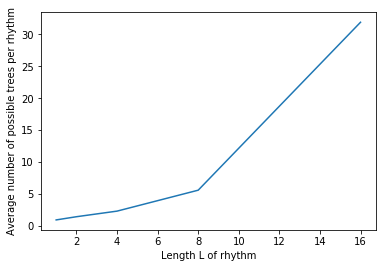

In [17]:
# Plot this all
bob = np.logspace(0, 4, 5, base=2)

#plt.yscale("symlog")
plt.plot(bob, total_number_trees_vec(bob) / total_number_rhythms_vec(bob))
plt.xlabel("Length L of rhythm")
plt.ylabel("Average number of possible trees per rhythm")
plt.show()

In [18]:
# Generated all possible rhythms and their probs
all_rhythms = np.ndarray(shape=(2**L, L))
all_probs =  np.zeros(2**L)

for i in range(2**L): # populating
    all_rhythms[i,:] = number_to_rhythm(i)
    all_probs[i] = prob_rhythm(all_rhythms[i])

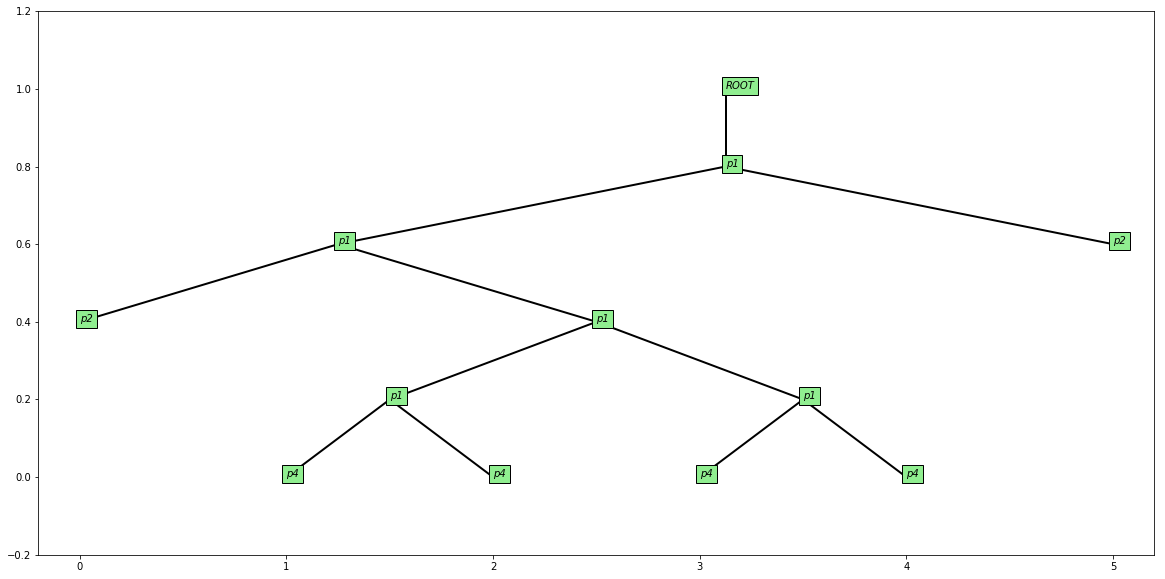

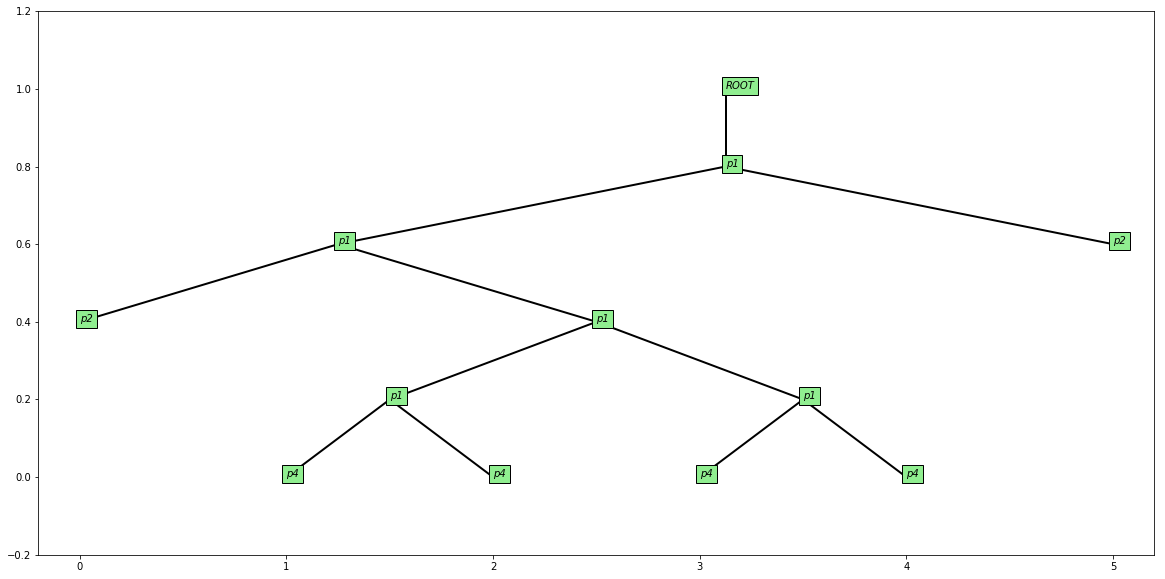

In [19]:
# Visualizer from Robert !!!!
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
string = "[ROOT%s]" %rhythm_parser(rhythm)[1]
parser = TreeParser(string, True)
fontsize = 15
parser.plot(ax=ax, padding=0.2, node_style={'facecolor': 'lightgreen'})
plt.show(0)

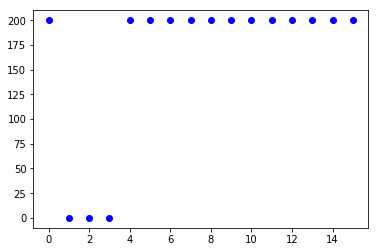

NameError: name 'generate_tempo' is not defined

In [20]:
#Generate the audio beat and play it
rhythm = generate_rhythm(L, 200, p1, p2)[0]
plt.plot(rhythm, 'bo')
plt.show()

degree   = 60   # pitch
track    = 0
channel  = 0
time     = 1    # In beats
duration = 1    # In beats
tempo    = bpm  # In BPM
volumes  = rhythm.astype(int).tolist()  # 0-127, as per the MIDI standard
tempos   = generate_tempo(L).astype(int).tolist()

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created automatically)
MyMIDI.addTempo(track, time, tempo)

# Rhythm
MyMIDI.addProgramChange(tracknum=0, channel=0, time=0, program = 115)
for i, volume in enumerate(volumes):
    MyMIDI.addNote(track=0, channel=0, pitch=50, time=time + i, duration=duration, volume=volume)
    
# Tempo
MyMIDI.addProgramChange(tracknum=0, channel=1, time=0, program = 115)    
for i, tempo in enumerate(tempos):
    MyMIDI.addNote(track=0, channel=1, pitch=90, time=time + i, duration=duration, volume=tempo)

with open("test.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

play_music("test.mid")

In [91]:
def WNBD(rhythm):
    meter = 4
    beats = np.nonzero(rhythm)[0]
    length = len(beats)
    
    T = np.zeros(length) # as in the paper
    W = np.zeros(length) # denominator weight for (finishes before meter, after meter...)
    D = np.zeros(length) # as in the paper
    
    T = np.minimum(beats % meter, -beats % meter)        
    
    for i in range(length-1): # length-1 because last beat has no next beat
        W[i] = int(beats[i+1]/4) - int(beats[i]/4) + 1
        if (W[i] > 2):
            W[i] = 1
    W[length-1] = int(len(rhythm)/4) - int(beats[length-1]/4) + 1 # last beat special case
    if (W[length-1] > 2): 
        W[length-1] = 1
    
    D = (W/T)[T !=0] # avoid div/0
    return np.sum(D)

WNBD(rhythm)

C:\Users\Me\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


6.0

In [21]:
# Functions for probabilities of notes to be played
def prob_to_be_played(size, level, p1, p2, p4=None):
    p4 = p4_from_p1p2(p1, p2, p4)
    acc = 0
    for i in range (int(N-level)):
        acc += p1**(i+level) * p2
    
    return p4 * p1**N + acc

vprob_to_be_played = np.vectorize(prob_to_be_played)

def levels(size):
    levels = np.zeros(size)
    
    for i in range(size):
        for j in range(N):
            if (i%(2**j) != 0):
                levels[i] += 1
                
    return levels
    
# Returns list of probs for each note in a template of length "size"
def probs_in_measure(size, p1, p2, p4=None):
    return vprob_to_be_played(size, levels(size), p1, p2, p4)

def expected_number_beats(size, p1, p2, p4=None):
    return np.sum(probs_in_measure(size, p1, p2, p4))

def variance_number_beats(size, p1, p2, p4=None):
    return np.sum(np.multiply(probs_in_measure(size, p1, p2, p4), 1 - probs_in_measure(size, p1, p2, p4)))

def probs_in_order(size, p1, p2, p4=None):
    probs = np.zeros(N)
    for i in range(N):
        probs[i] = vprob_to_be_played(size, i, p1, p2, p4)
    return probs

In [22]:
# Returns INPUTS for a Constant expected number of rhythms being played
def constant_expected_value(scale, constant, max_deviation):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        E = expected_number_beats(L, i/scale, j/scale)
        if(constant - max_deviation <= E <= constant + max_deviation):
            d[(i, j, k)] = E
    return np.asarray(list(d.keys()))/scale

constant_expected_value(40, 6, 1)

array([[0.65 , 0.35 , 0.   ],
       [0.675, 0.3  , 0.025],
       [0.675, 0.325, 0.   ],
       [0.7  , 0.275, 0.025],
       [0.7  , 0.3  , 0.   ],
       [0.725, 0.225, 0.05 ],
       [0.725, 0.25 , 0.025],
       [0.725, 0.275, 0.   ],
       [0.75 , 0.2  , 0.05 ],
       [0.75 , 0.225, 0.025],
       [0.775, 0.15 , 0.075],
       [0.775, 0.175, 0.05 ],
       [0.775, 0.2  , 0.025],
       [0.8  , 0.125, 0.075],
       [0.8  , 0.15 , 0.05 ],
       [0.825, 0.1  , 0.075],
       [0.825, 0.125, 0.05 ],
       [0.85 , 0.1  , 0.05 ],
       [0.875, 0.075, 0.05 ],
       [0.9  , 0.05 , 0.05 ],
       [0.95 , 0.025, 0.025]])

In [23]:
next_x = 1000  # We start the search at x=6
gamma = 0.01  # Step size multiplier
precision = 0.00001  # Desired precision of result
max_iters = 10000  # Maximum number of iterations

# Derivative function
df = lambda x: 

for i in range(max_iters):
    current_x = next_x
    next_x = current_x - gamma * df(current_x)
    step = next_x - current_x
    if abs(step) <= precision:
        break

print("Minimum at", next_x)

# The output for the above will be something like
# "Minimum at 2.2499646074278457"

SyntaxError: invalid syntax (<ipython-input-23-e13e32c848ba>, line 7)

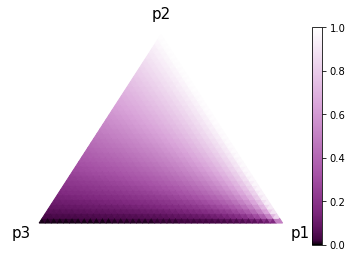

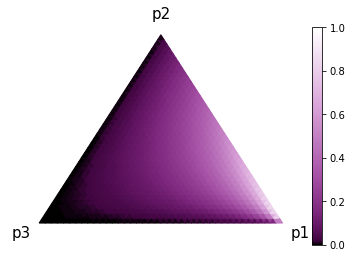

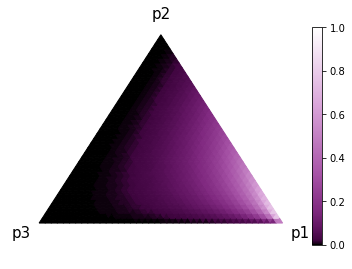

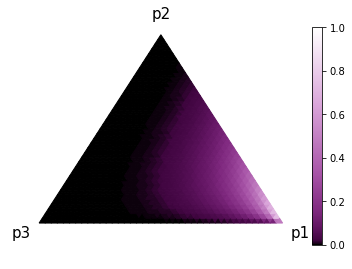

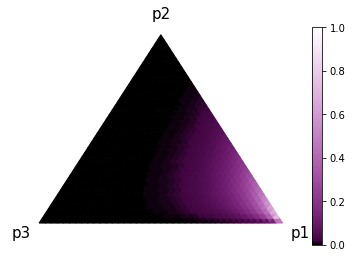

In [32]:
# Simplex search for ternary plotting
scale = 40
def generate_heatmap_data(scale=scale, level=0):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = probs_in_order(L, i/scale, j/scale)[level]
    return d

for level in range(N):
    data = generate_heatmap_data(scale, level)
    figure, tax = ternary.figure(scale=scale)
    tax.heatmap(data, style="triangular", cmap=cmap, vmin=0, vmax=1)
    #tax.boundary()
    fontsize = 15
    # tax.set_title("Probability of a beat level %s to be played" %level, fontsize=fontsize,y=1.12)
    tax.left_corner_label("p3", fontsize=fontsize)
    tax.right_corner_label("p1", fontsize=fontsize)
    tax.top_corner_label("p2", fontsize=fontsize)
    plt.axis('off')
    plt.savefig("graphs/ternary_%s.png" %level, dpi=400, bbox_inches='tight')
    plt.plot()

plt.show()

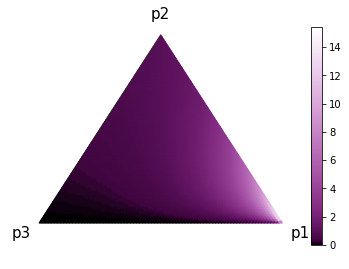

In [36]:
#Graph for expected number of beats
scale = 80
def generate_heatmap_data(scale=scale):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = expected_number_beats(L, i/scale, j/scale)
    return d

data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", cmap=cmap, vmin=0)
#tax.boundary()
fontsize = 15
# tax.set_title("Expected number of beats if L=%s" %L, fontsize=fontsize,y=1.12)
tax.left_corner_label("p3", fontsize=fontsize)
tax.right_corner_label("p1", fontsize=fontsize)
tax.top_corner_label("p2", fontsize=fontsize)
plt.axis('off')
plt.savefig("graphs/expected_value", dpi=400, bbox_inches='tight')
plt.plot()

plt.show()

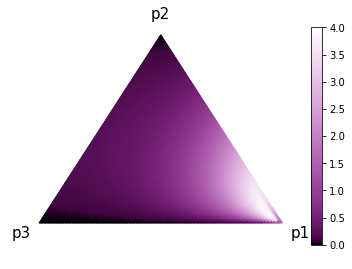

In [35]:
#Graph for variance of beats
scale = 80
def generate_heatmap_data(scale=scale):
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = variance_number_beats(L, i/scale, j/scale)
    return d

data = generate_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", cmap=cmap)
#tax.boundary()
fontsize = 15
#tax.set_title("Variance in # of beats if L=%s" %L, fontsize=fontsize,y=1.12)
tax.left_corner_label("p3", fontsize=fontsize)
tax.right_corner_label("p1", fontsize=fontsize)
tax.top_corner_label("p2", fontsize=fontsize)
plt.axis('off')
plt.savefig("graphs/variance", dpi=400, bbox_inches='tight')
plt.plot()

plt.show()